# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [2]:
df = pd.read_csv('bikes_rent.csv')
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,10.486773,2114
727,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,4.656485,3095
728,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,3.725374,1341
729,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,10.505372,1796


Для каждого дня проката известны следующие признаки:
* `season`: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`: 0 - 2011, 1 - 2012
* `mnth`: от 1 до 12
* `holiday`: 0 - нет праздника, 1 - есть праздник
* `weekday`: от 0 до 6
* `workingday`: 0 - нерабочий день, 1 - рабочий день
* `weathersit`: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`: температура в Цельсиях
* `atemp`: температура по ощущениям в Цельсиях
* `hum`: влажность
* `windspeed(mph)`: скорость ветра в милях в час
* `windspeed(ms)`: скорость ветра в метрах в секунду
* `cnt`: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

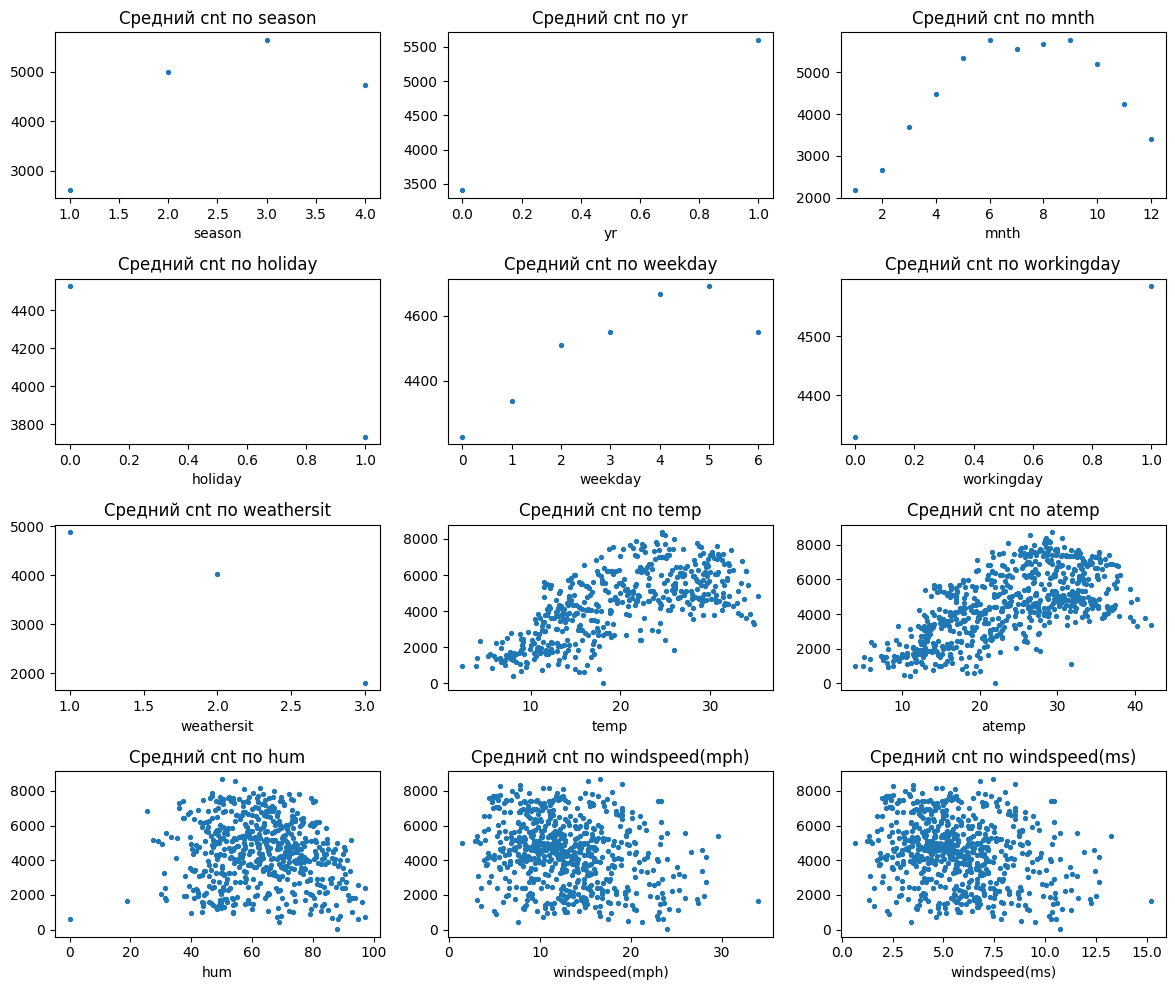

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Список группировок
features = [
    "season",
    "yr",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed(mph)",
    "windspeed(ms)",
]

fig, axes = plt.subplots(4, 3, figsize=(12, 10))


axes = axes.ravel()

for i, column in enumerate(features):
    ax = axes[i]

    data = df.groupby(column).cnt.mean().reset_index()
    ax.scatter(data[column], data["cnt"], s=8)
    ax.set_xlabel(column)
    ax.set_title(f"Средний cnt по {column}")

plt.tight_layout()
plt.show()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?

- Очень похоже на параболу $y = ax^2 + bx + c$

2. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

- Графики с двумя точками учмтывать не будем. По зависимостям с больши количеством точек очень похоже, что число прокатов зависит линейно от 
    * $\text{temp}$ (температуры), 
    * $\text{atemp}$ (ощущуемой температуре). 

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [4]:
df.corrwith(df.cnt).sort_values().iloc[:-1]

weathersit       -0.297391
windspeed(ms)    -0.234545
windspeed(mph)   -0.234545
hum              -0.100659
holiday          -0.068348
workingday        0.061156
weekday           0.067443
mnth              0.279977
season            0.406100
yr                0.566710
temp              0.627494
atemp             0.631066
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [5]:
selected_features = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]
selected_df = df[selected_features]
selected_df.corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [6]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.utils import shuffle

In [8]:
df_shuffled = shuffle(df, random_state=42)
X = scaler.fit_transform(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
df_shuffled

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
703,4,1,12,0,2,1,1,19.509153,23.45270,73.3750,11.666643,5.215308,6606
33,1,0,2,0,4,1,1,7.665237,8.89390,43.7826,18.609384,8.318902,1550
300,4,0,10,0,5,1,2,13.564153,15.94060,58.5833,15.375093,6.873086,3747
456,2,1,4,0,0,0,2,17.459153,20.86435,67.6250,11.541889,5.159539,6041
633,4,1,9,0,2,1,1,22.550000,27.20895,57.0000,15.833507,7.078009,7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,1,0,3,0,0,0,1,15.758268,19.00455,52.7391,18.130468,8.104814,2417
106,2,0,4,0,0,0,1,18.723347,22.28480,47.9583,20.334232,9.089956,3744
270,4,0,9,0,3,1,2,26.035000,28.75790,84.8750,9.958143,4.451561,3907
435,1,1,3,0,0,0,1,14.831299,17.98350,47.6957,14.913329,6.666665,4911


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [9]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [10]:
linear_regressor = LinearRegression()
linear_regressor.fit(X, y)
original_weights = list(zip(df.columns[:-1], linear_regressor.coef_))
linear_feature_weight = pd.DataFrame(original_weights, columns=['feature', 'weight']).sort_values(by='weight').reset_index(drop=True)
linear_feature_weight

,feature,weight
0,windspeed(ms),-1.245436e+13
1,weathersit,-3.302272e+02
2,hum,-1.456155e+02
3,mnth,-1.413006e+02
4,holiday,-8.675760e+01
5,workingday,5.638980e+01
6,weekday,1.372273e+02
7,temp,3.674799e+02
8,season,5.708636e+02
9,atemp,5.855522e+02


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [11]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)
lasso_weights = list(zip(df.columns[:-1], lasso_regressor.coef_))
lasso_series = pd.Series(dict(lasso_weights), name='Weights').round(2).replace(-0.00, 0)
print(lasso_series)

season             560.24
yr                1019.46
mnth              -128.73
holiday            -86.15
weekday            137.35
workingday          55.21
weathersit        -332.37
temp               376.36
atemp              576.53
hum               -144.13
windspeed(mph)    -197.14
windspeed(ms)        0.00
Name: Weights, dtype: float64


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [12]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
ridge_weights = list(zip(df.columns[:-1], ridge_regressor.coef_))
ridge_series = pd.Series(dict(ridge_weights), name='Weights').round(2)
print(ridge_series)

season             563.06
yr                1018.95
mnth              -131.87
holiday            -86.75
weekday            138.01
workingday          55.90
weathersit        -332.35
temp               386.46
atemp              566.35
hum               -145.07
windspeed(mph)     -99.26
windspeed(ms)      -99.26
Name: Weights, dtype: float64


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из $\alpha$'s обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список `coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [13]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)
    
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проанализируйте динамику весов при увеличении параметра регуляризации:

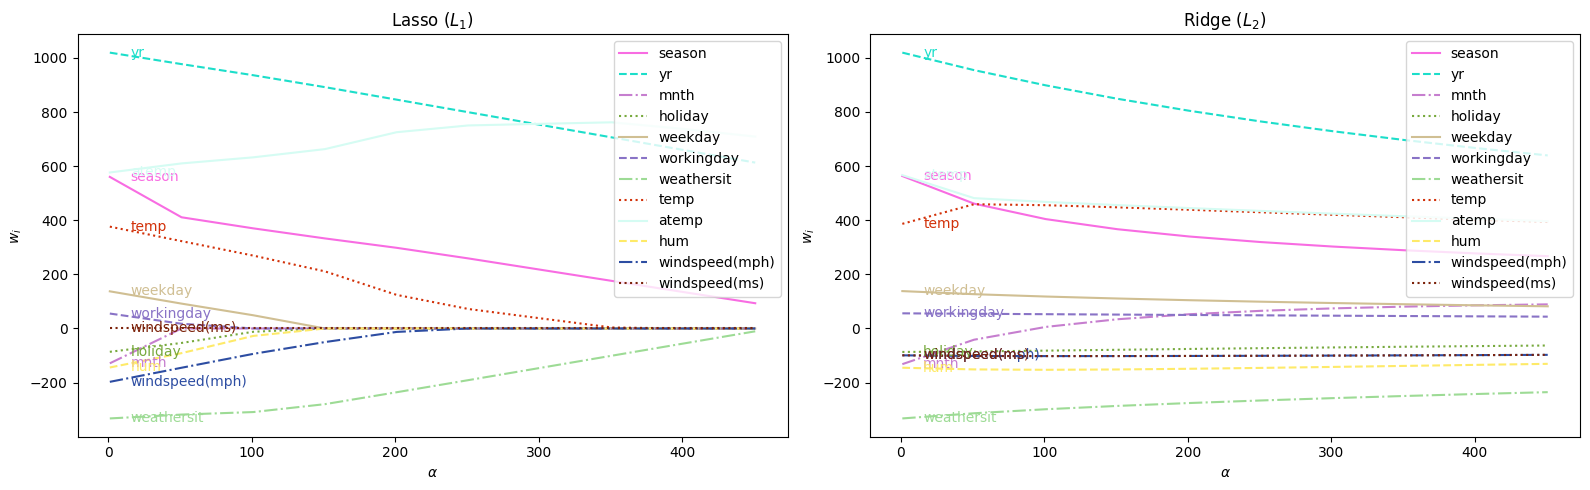

In [14]:
# Generate a set of random colors for the features
feature_colors = np.random.rand(len(df.columns), 3)

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Define line styles
line_styles = ["-", "--", "-.", ":", "solid", "dashed", "dashdot", "dotted"]


# Function to plot coefficients with different line styles and annotations
def plot_coefficients(ax, coefs, alphas, title):
    for i, (coef, feature) in enumerate(zip(coefs.T, df.columns)):
        line_style = line_styles[i % len(line_styles)]  # Cycle through line styles
        ax.plot(
            alphas, coef, label=feature, color=feature_colors[i], linestyle=line_style
        )

        # Add annotations (feature names) near the lines
        index = int(0.0 * len(alphas))  # Index for annotation (10% from the start)
        annotation_x = alphas[index]
        annotation_y = coef[index]
        ax.annotate(
            feature,
            xy=(annotation_x, annotation_y),
            xytext=(15, 0),
            textcoords="offset points",
            color=feature_colors[i],
            fontsize=10,
            va="center",
        )

    ax.legend(loc="upper right")
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(r"$w_i$")
    ax.set_title(title)


# Plot Lasso coefficients on the left subplot
plot_coefficients(ax1, coefs_lasso, alphas, "Lasso ($L_1$)")

# Plot Ridge coefficients on the right subplot
plot_coefficients(ax2, coefs_ridge, alphas, "Ridge ($L_2$)")

plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же $\alpha$?
- Лассо агрессивнее уменьшает веса при одном и том же $\alpha$.
2. Что произойдет с весами `Lasso`, если $\alpha$ сделать очень большим? Поясните, почему так происходит.
- Когда параметр регуляризации $\alpha$ в методе `Lasso` становится очень большим, веса признаков будут стремиться к нулю $w_i \to 0$. Это происходит из-за особенности L1-регуляризации, которая вводит штраф за абсолютные значения весов. При увеличении $\alpha$ штраф за большие абсолютные значения весов становится более значительным, чем штраф за ошибку на тренировочных данных. Поэтому, если $\alpha$ становится очень большим, большинство весов признаков будут близки к нулю, и некоторые из них могут даже точно обнулиться. Это может привести к упрощению модели и выбору только наиболее важных признаков. Все же нужно как-то научится подбирать оптимальное значение $\alpha$ в зависимости от конкретной задачи и данных, чтобы достичь баланса между регуляризацией и точностью модели.
3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении $\alpha > 0$? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
- Я вижу, что `windspeed(ms)` занулилось приктически при $\alpha \gtrsim 0$ для $L_1$. У $L_2$ такого поведения нету.
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?
- Очевидно, это $L_1$.

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении $\alpha$ модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее $\alpha$.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать $\alpha$ по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения $\alpha$, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ частей, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в `sklearn` совсем просто: для этого есть специальный регрессор, `LassoCV`, который берет на вход список из $\alpha$ и для каждого из них вычисляет `MSE` на кросс-валидации. После обучения (если оставить параметр $cv=3$ по умолчанию) регрессор будет содержать переменную `mse_path_` - матрицу размера `len(alpha) x k`, $k = 3$ (число блоков в кросс-валидации), содержащую значения `MSE` на тесте для соответствующих запусков. Кроме того, в переменной `alpha_` будет храниться выбранное значение параметра регуляризации, а в `coef_`, традиционно, обученные веса, соответствующие этому `alpha_`.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по $\alpha$'s; для сопоставления с матрицей `MSE` лучше использовать переменную регрессора `alphas_`.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [15]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

lasso_cv_regressor = LassoCV(alphas=alphas, cv=3)
lasso_cv_regressor.fit(X, y)

x = lasso_cv_regressor.alphas_
y = lasso_cv_regressor.mse_path_.mean(axis=1)

In [16]:
mse = pd.DataFrame(lasso_cv_regressor.mse_path_, y)
mse.index = x
mse.index.name = 'alpha'
mse['Mean'] = mse.mean(axis=1)
mse.columns = ['k_1', 'k_2', 'k_3', 'Mean']
mse.index.name = 'alpha'
mse.sort_index()

,k_1,k_2,k_3,Mean
alpha,,,,
1,746611.463677,799433.167369,809120.809315,785055.146787
6,733725.760405,804415.013271,806452.498783,781531.090820
11,735622.015883,810953.613786,804327.502204,783634.377291
16,738465.373934,819052.826942,802734.321640,786750.840839
21,742255.052129,824464.629171,801674.308308,789464.663203
26,746878.990466,829029.793324,801117.803507,792342.195766
31,750399.068638,833901.906581,799482.706783,794594.560667
36,754320.422474,839080.963108,798251.324397,797217.569993
41,758643.053536,844566.955891,797423.732959,800211.247462


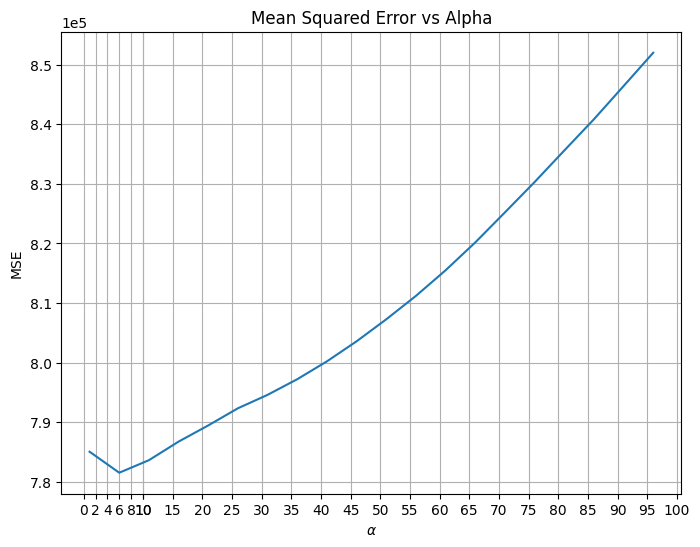

Oprimal alpha =  6
Optimal weights =  [ 532. 1015. -100.  -83.  133.   52. -331.  371.  581. -140. -192.   -0.]


In [17]:
def create_plot(
    data, title, xlabel, ylabel, figsize=None, int1=(0, 11, 2), int2=(10, 101, 5)
):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = data["x"]
    y = data["y"]

    plt.plot(x, y)  # тут тим нужно менять

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    x_ticks_1 = np.arange(*int1)
    x_ticks_2 = np.arange(*int2)
    x_ticks = np.concatenate((x_ticks_1, x_ticks_2))  # Combine the two intervals
    plt.xticks(x_ticks)
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    plt.grid()
    plt.show()


plot_data = {"x": mse.index, "y": mse["Mean"]}

create_plot(
    plot_data, "Mean Squared Error vs Alpha", r"$\alpha$", "MSE", figsize=(8, 6)
)

print("Oprimal alpha = ", lasso_cv_regressor.alpha_)
print("Optimal weights = ", lasso_cv_regressor.coef_.round(0))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали $\alpha$, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории `MSE`, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


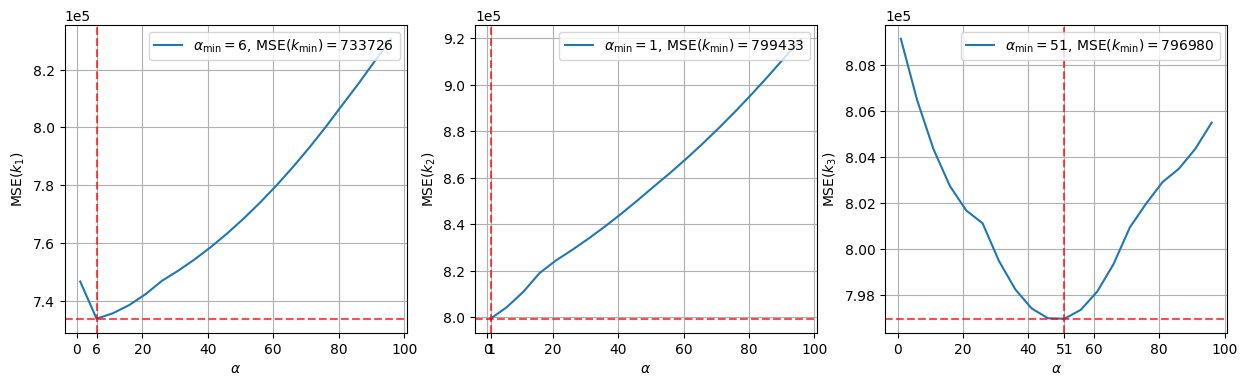

In [18]:
min_indices = {i: mse.iloc[:, i].idxmin() for i in range(0, 3)}
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for col, min_index in min_indices.items():
    axes[col].plot(
        mse.index,
        mse[f"k_{col+1}"],
        label=r"$\alpha_{{\min}} = {}$, $\mathrm{{MSE}}(k_{{\min}}) = {:.0f}$".format(
            min_index, mse.loc[min_index, f"k_{col+1}"]
        ),
    )
    axes[col].set_xlabel(r"$\alpha$")
    axes[col].set_ylabel(rf"MSE($k_{col+1}$)")
    axes[col].ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    axes[col].grid(which="both")
    axes[col].legend(loc='upper right')

    main_ticks = np.arange(0, 101, 20)  

    tick = min_index
    ytick = mse.loc[min_index, f"k_{col+1}"]
   
    all_ticks = np.sort(np.concatenate((main_ticks, [tick])))
    
    axes[col].axvline(x=tick, color='red', linestyle='--', alpha=0.7)
    axes[col].axhline(y=ytick, color='red', linestyle='--', alpha=0.7)
    
    axes[col].set_xticks(all_ticks)

plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое `MSE` на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

Поучим оптимизированные веса метода `LassoCV` и наложим маску положительных коэвициентов

In [19]:
sorted_indices = lasso_cv_regressor.coef_.argsort()[::-1][:4]
lasso_cv_feture_weight = pd.DataFrame(zip(features, lasso_cv_regressor.coef_), columns=['Feature', 'Lasso CV Weight'])
lasso_cv_feture_weight_positive = lasso_cv_feture_weight.iloc[sorted_indices].reset_index(drop=True)
lasso_cv_feture_weight_positive


,Feature,Lasso CV Weight
0,yr,1015.060223
1,atemp,581.396931
2,season,532.018983
3,temp,370.679855


In [20]:
# Вспомним еще нерегуляризированные коэфициенты дл тех же свойств
linear_feture_weight = pd.DataFrame(zip(features, linear_regressor.coef_), columns=['Feature', 'Linear Weight'])
linear_feture_weight_positive = linear_feture_weight.iloc[sorted_indices].reset_index(drop=True)
positive_weights = pd.concat([lasso_cv_feture_weight_positive, linear_feture_weight_positive.drop(columns=['Feature'])], axis=1)
positive_weights

,Feature,Lasso CV Weight,Linear Weight
0,yr,1015.060223,1021.960425
1,atemp,581.396931,585.552180
2,season,532.018983,570.863642
3,temp,370.679855,367.479903


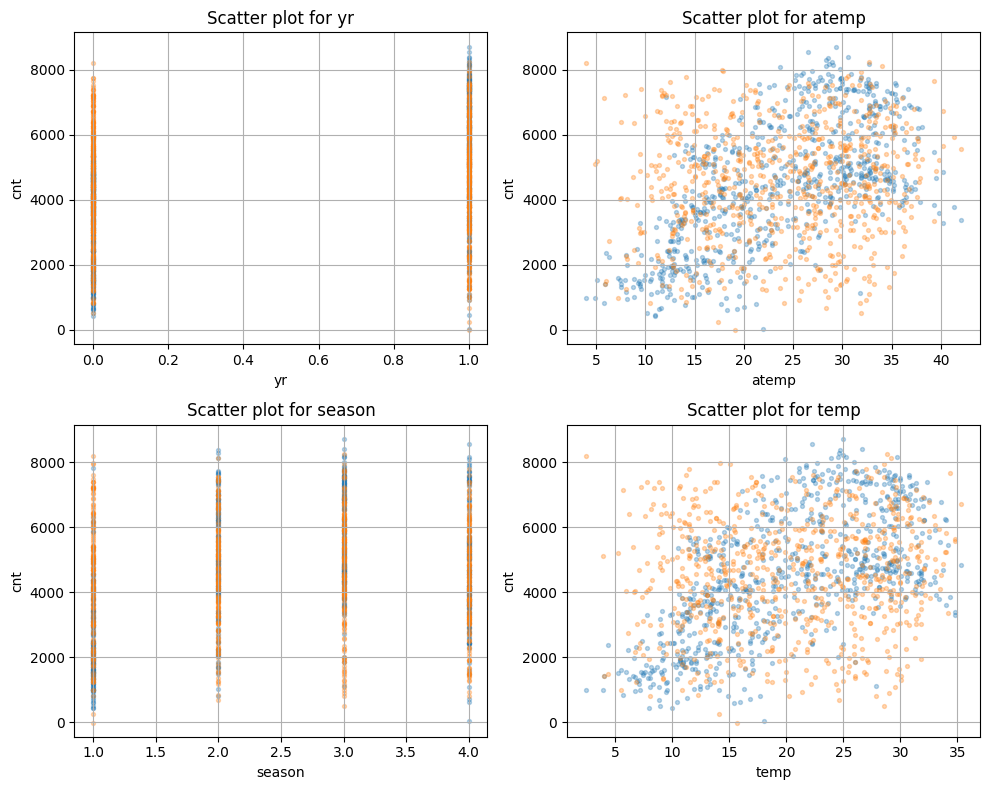

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

y_predict_linear = linear_regressor.predict(X)
df['linear'] = y_predict_linear

y_predict_lasso = lasso_cv_regressor.predict(X)
df['lasso'] = y_predict_lasso


for i, (feature, lass_weight, linear_weight) in positive_weights.iterrows():
    ax = axes[i]  
    
    x = df[feature]
    y = df.cnt
    ax.scatter(x, y, s=8, alpha=0.3)
    # ax.scatter(x, df.linear, alpha=0.3, s=8)
    ax.scatter(x, df.lasso, alpha=0.3, s=8)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('cnt')
    ax.set_title(f'Scatter plot for {feature}')
    ax.grid()
    # ax.legend()

plt.tight_layout()
plt.show()

__Ответ:__
1. Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? 
- Да, видна

2. Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 
- Точно можно утверждать, что от температур (обьеих) до $35^\circ$C зависит число арендованных велосипедов. Далее может убывать, но наша модель линейна, и этого уже не рассмотреть. От сезона в рамках линейной модели можна такое тоже утверждать. Что касается года... мало данных.


#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

In [22]:
sorted_indices = lasso_cv_regressor.coef_.argsort()[::1][:3]
lasso_cv_feture_weight_negative = lasso_cv_feture_weight.iloc[sorted_indices].reset_index(drop=True)
lasso_cv_feture_weight_negative

,Feature,Lasso CV Weight
0,weathersit,-330.559857
1,windspeed(mph),-191.771408
2,hum,-140.007406


In [23]:
# Вспомним еще нерегуляризированные коэфициенты дл тех же свойств
linear_feture_weight_negative = linear_feture_weight.iloc[sorted_indices].reset_index(drop=True)
negative_weights = pd.concat([lasso_cv_feture_weight_negative, linear_feture_weight_negative.drop(columns=['Feature'])], axis=1)
negative_weights

,Feature,Lasso CV Weight,Linear Weight
0,weathersit,-330.559857,-3.302272e+02
1,windspeed(mph),-191.771408,1.245436e+13
2,hum,-140.007406,-1.456155e+02


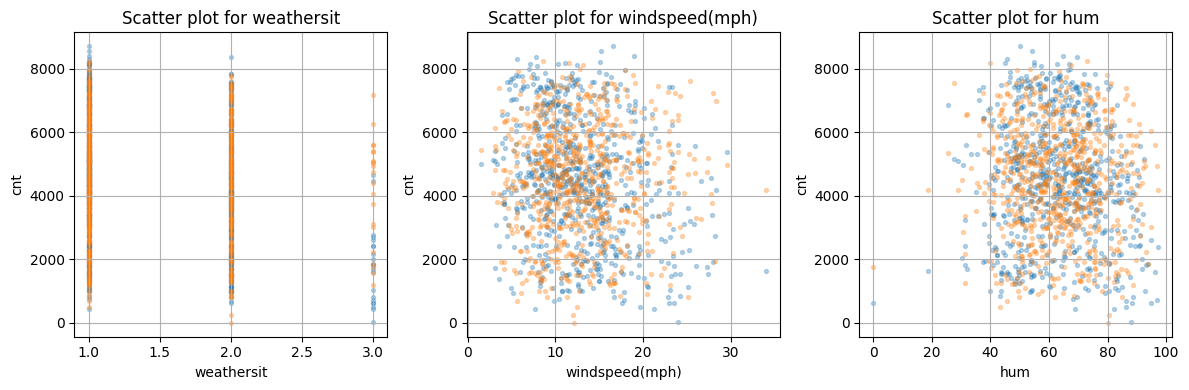

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.ravel()

for i, (feature, lass_weight, linear_weight) in negative_weights.iterrows():
    ax = axes[i]  
    
    x = df[feature]
    y = df.cnt
    ax.scatter(x, y, s=8, alpha=0.3)
    # ax.scatter(x, df.linear, alpha=0.3, s=8)
    ax.scatter(x, df.lasso, alpha=0.3, s=8)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('cnt')
    ax.set_title(f'Scatter plot for {feature}')
    ax.grid()
    # ax.legend()

plt.tight_layout()
plt.show()

__Ответ:__

Видна ли убывающая линейная зависимость? 
- если точки предсказаний группиоуются вокруг экспериментальных, то да, можно утверждать, что зависимость похожа на линейную.

Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?
- можно, по группировке точек модели и данных.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

In [25]:
lasso_cv_feture_weight[abs(lasso_cv_feture_weight['Lasso CV Weight'])<1e-3]

,Feature,Lasso CV Weight
11,windspeed(ms),-2.685470e-08


__Ответ:__

Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? 
- регуляризация $L_1$ исключила лиейно-зависимую величину (в даном случае она "повторяет" `windspeed(mph)`) и сделела вычислимой матрицу признаков 


$$ \vec{w}^* = \left(\mathbf{X}^{\mathrm{T}} \mathbf{X} + \alpha\| w \|\right)^{-1}\mathbf{X}^{\mathrm{T}} \vec{y}. $$


Верно ли, что они никак не влияют на спрос на велосипеды?

- Не верно. Оно точно повторяет влияние `windspeed(mph)`.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.